# A Comparision Between Complete State Tomography and Shadow Tomography

***
## Complete State Tomography

### Overview

The aim of complete state tomography is to reconstruct a target quantum state through a series of projective measurements. *Mention Born's rule, destruction of a state due to measurement, and the curse of dimensionality to motivate scaling.*

### Theory

For single-qubit states the general expression for their density matrices can be written uniquely as:
$$\hat{\rho} = \frac{1}{2} \sum_{i=0}^{3} S_i \hat{\sigma}_i. \tag{1}$$
Where $\hat{\sigma}_i$ are the Pauli matrices (Including the 2x2 identity matrix as $\hat{\sigma}_0$) and $S_i$ are the values given by:
$$S_i = Tr\{\hat{\sigma}_i\hat{\rho}\}. \tag{2}$$
It is also useful to note that, 
1. For all pure states: $\sum_{i=1}^{3} S_i^2 = 1$.
2. For mixed states: $\sum_{i=1}^{3} S_i^2 < 1$.
3. For the completely mixed state:  $\sum_{i=1}^{3} S_i^2 = 0$.
4. Due to the normalization condition for quantum states it is always the case that: $S_0^2 = 1$.

Equations (1) and (2) are from pages 4 and 5 of [Quantum State Tomography](#references). Proofs of (1) and (2) to be added in the future.

For a quantum state represented by density matrix $\hat{\rho}$ the expectation value for an observable $\hat{\Omega}$ is given by:
$$\langle \hat{\Omega} \rangle = \sum_{i} p_i \bra{i} \hat{\Omega} \ket{i} = Tr \{ \hat{\Omega} \hat{\rho} \}. \tag{3}$$
Thus, using (1) and (3), we can represent the density matrix for a single-qubit state as:
$$\hat{\rho} = \frac{1}{2} \sum_{i=0}^{3} \langle \hat{\sigma}_i \rangle \hat{\sigma}_i. \tag{4}$$

For multiple-qubit states the general expression for their density matrices can be written as:
$$ \hat{\rho} = \frac{1}{2^n} \sum_{i_1,i_2,\dots,i_n = 0}^{3} S_{i_1,i_2,\dots,i_n} \hat{\sigma}_{i_1} \otimes \hat{\sigma}_{i_2} \otimes \dots \hat{\sigma}_{i_n}. \tag{5}$$
Where $\hat{\sigma}_i$ are still the Pauli matrices (Including the 2x2 identity matrix as $\hat{\sigma}_0$) and $S_{i_1,i_2,\dots,i_n}$ are the values given by:
$$ S_{i_1,i_2,\dots,i_n} = Tr\{ \hat{\sigma}_{i_1,i_2,\dots,i_n} \hat{\rho} \} = Tr\{ (\hat{\sigma}_{i_1} \otimes \hat{\sigma}_{i_2} \otimes \dots \hat{\sigma}_{i_n}) \hat{\rho} \} \tag{6}$$

Equations (5) and (6) are from page 11 of [Quantum State Tomography](#references).

Similarly, using (5) and (6), we can represent the density matrix for an n-qubit state as:
$$ \hat{\rho} = \frac{1}{2^n} \sum_{i_1,i_2,\dots,i_n = 0}^{3} \langle \hat{\sigma}_{i_1,i_2,\dots,i_n} \rangle \hat{\sigma}_{i_1} \otimes \hat{\sigma}_{i_2} \otimes \dots \hat{\sigma}_{i_n}. \tag{7}$$

> Note: Above we only considered the orthogonal measurement bases of the pauli matrices. We are not constrained to orthogonal measurement bases and can instead use any set of linearly independent projective measurements (see pages 5 and 6 of [Quantum State Tomography](#references) for the single-qubit case and pages 11 and 12 of [Quantum State Tomography](#references) for the multiple-qubit case.).

### The "Algorithm"

#### Importing necessary libraries

In [40]:
import numpy as np
import itertools

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Clbit
from qiskit.circuit.library import *
from qiskit.primitives import StatevectorSampler, Estimator
from qiskit.quantum_info import DensityMatrix

#### Function for generating an approximation of the $\rho$ prepared by the input circuit using complete state tomography as describe in [Quantum State Tomography](#references)

In [41]:
def complete_state_tomography(circuit, samples):
    """
    Perform complete state tomography on a state prepared by a quantum circuit. 
    
    Args:
        circuit (QuantumCircuit): The quantum circuit that prepares the state.
        samples (int): The number of samples to use in the tomography.

    Returns:
        np.ndarray: The density matrix of the state.
    """

    # The Pauli matrices.
    I = [[1,0],[0,1]]
    X = [[0,1],[1,0]]
    Y = [[0,-1j],[1j,0]]
    Z = [[1,0],[0,-1]]

    # Get the number of qubits in the circuit.
    num_qubits = circuit.num_qubits

    # Create a matrix to store the density matrix.
    rho = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)

    # Generate the measurement scheme using the cartesian product.
    measurement_scheme = []

    for measurement in (itertools.product(['I','X','Y','Z'], repeat=num_qubits)):
        measurement_scheme.append(measurement)

    # An array to store the measurement results.
    results = np.zeros(4**num_qubits)

    # Create a estimator to simulate the quantum circuit a "samples" amount of shots.
    estimator = Estimator(options = ({'shots':samples}))

    # Perform the measurements. This generates the S coefficients in equation (6) above.
    for i, measurement in enumerate(measurement_scheme):
        
        # Run the sampler on the quantum circuit and store the result.
        results[i] = estimator.run(circuits = [circuit], observables = [''.join(measurement)]).result().values[0]
        
    # Calculate the density matrix. This is just an implementation of equation (5) above.
    for i, measurement in enumerate(measurement_scheme):

        o = [1]
        for j in measurement:
            match j:
                case 'I':
                    o = np.kron(o, I)
                case 'X':
                    o = np.kron(o, X)
                case 'Y':
                    o = np.kron(o, Y)
                case 'Z':
                    o = np.kron(o, Z)
        rho += results[i] * o

    return rho/2**num_qubits

Using the function ``operator_distance`` we can determine how "close" the reconstructed state is to the true state.

In [42]:
def operator_distance(A, B):
    """
    Calculate the distance between two operators using the Frobenius norm.

    Args:
        A (np.array): The first operator.
        B (np.array): The second operator.

    Returns:
        float: The distance between the two operators.
    """

    return np.linalg.norm((A - B), ord = 'fro')

### Examples

#### With an arbitrary single qubit state

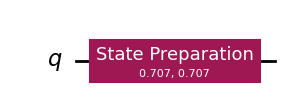

In [43]:
# Instantiate a quantum register for a single qubit.
single_qubit_qr = QuantumRegister(1, 'q')

# Coefficients for the arbitrary state.
a = 1
b = 1

# Create a quantum circuit which prepares the single qubit state into an arbitrary state based on coefficients a and b.
single_qubit_qc = QuantumCircuit(single_qubit_qr)
single_qubit_qc.prepare_state(state = [a/(np.sqrt(a**2 + b**2)), b/(np.sqrt(a**2 + b**2))], qubits = [0])

# Draw the circuit in mpl (matplotlib).
single_qubit_qc.draw('mpl')

In [44]:
rho_true = DensityMatrix.from_instruction(single_qubit_qc)
print("True density matrix:")
print(rho_true.data)

rho_tomo = complete_state_tomography(single_qubit_qc, 1000)
print("\nDensity matrix from tomography:")
print(np.round(rho_tomo, 2))

print("\nDistance between the true and tomography density matrices:")
print(np.round(operator_distance(rho_true.data, rho_tomo), 4))

True density matrix:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]

Density matrix from tomography:
[[0.51+0.j 0.5 +0.j]
 [0.5 -0.j 0.49+0.j]]

Distance between the true and tomography density matrices:
0.0076


#### With a Bell state

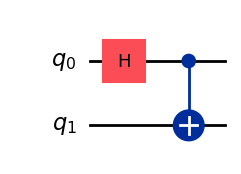

In [45]:
# Instantiate a quantum register with two qubits.
bell_state_qr = QuantumRegister (2, 'q')

# Create a quantum circuit with a hadamard gate acting on qubit 0
# and a CNOT gate with control qubit 0 and target qubit 1. This will prepare a bell state.
bell_state_qc = QuantumCircuit(bell_state_qr)
bell_state_qc.h(0)
bell_state_qc.cx(0, 1)

# Draw the ciruit in mpl (matplotlib).
bell_state_qc.draw("mpl")

In [46]:
rho_true = DensityMatrix.from_instruction(bell_state_qc)
print("True density matrix:")
print(rho_true.data)

rho_tomo = complete_state_tomography(bell_state_qc, 1000)
print("\nDensity matrix from tomography:")
print(np.round(rho_tomo, 2))

print("\nDistance between the true and tomography density matrices:")
print(np.round(operator_distance(rho_true.data, rho_tomo), 4))

True density matrix:
[[0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]]

Density matrix from tomography:
[[ 0.48+0.j   -0.  +0.01j  0.01-0.01j  0.5 +0.02j]
 [-0.  -0.01j  0.01+0.j   -0.  -0.01j -0.02+0.02j]
 [ 0.01+0.01j -0.  +0.01j -0.01+0.j    0.  -0.j  ]
 [ 0.5 -0.02j -0.02-0.02j  0.  +0.j    0.52+0.j  ]]

Distance between the true and tomography density matrices:
0.0584


***
## Shadow Tomography

### Overview

For many situations a complete description of a quantum state is not of interest but rather the expectation values of some set of observables. In a paper titled *Shadow Tomography of Quantum States* Scott Aaronson introduces the idea that a complete description of a state is not required to accurately estimate some subset of all target observables on the state. Then in a paper titled *Predicting Many Properties of a Quantum System from Very Few Measurements* Huang, Kueng, and Preskill develop and prove the efficiency of the method of classical shadows.

### Theory

## The Method of Classical Shadows

### The "Algorithm"

#### Importing necessary libraries

In [47]:
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Clbit
from qiskit.circuit.library import *
from qiskit.primitives import StatevectorSampler, Estimator
from qiskit.quantum_info import DensityMatrix

#### Function for generating the classical shadow

In [48]:
def generate_classical_shadow(circuit, shadow_size):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/
    Given a quantum circuit, this function creates a collection of bit-strings generated by random single-qubit Pauli measurements and records the associated random pauli measurement.

    Args:
        circuit (QuantumCircuit): The quantum circuit which resulting state we wish to estimate.
        shadow_size (int): The number of random Pauli measurements to be taken.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        np.ndarray: A matrix of shape (shadow_size, num_qubits) where each row is a bit-string representing the result of a random Pauli measurement on the qubits.
        np.ndarray: A matrix of shape (shadow_size, num_qubits) where each row is a sequence of integers representing the Pauli measurement scheme used to generate the corresponding bit-string in the first matrix.
    """

    # Get the number of qubits in the circuit.
    num_qubits = circuit.num_qubits

    # Generate the measurement scheme. This is the random Pauli measurements that will be done on the qubits after each shot of the circuit.
    measurement_scheme = np.random.randint(0, 3, size = (shadow_size, num_qubits))

    # Create a matrix to store the results of the measurements.
    measurements = np.zeros(shape = (shadow_size, num_qubits))

    # Create a sampler to simulate the quantum circuit on a single shot.
    sampler = StatevectorSampler(default_shots=1)

    # 
    for i in range(shadow_size):

        # Apply the measurement scheme to the qubits
        qc = QuantumCircuit.copy(circuit)

        for j in range(num_qubits):
            if measurement_scheme[i][j] == 0:
                qc.h(j)
            elif measurement_scheme[i][j] == 1:
                qc.s(j)
                qc.h(j)
            else:
                continue

        qc.measure_all()

        # Run the sampler on the quantum circuit and store the result.
        result = sampler.run([qc]).result()[0]

        # A change

        # Store the bit-strings representing the measured basis states. Because the sampler is configured to run the circuit once, there is only one result.
        counts = result.data.meas.get_counts()   

        # Get the single bit-string.
        states = list(list(counts.keys())[0])
        # The bit string is ordered with qubit n on the left and qubit 0 on the right. We want to reverse this order.
        states.reverse()

        # Store the results of the measurements.
        for j in range(num_qubits):
            measurements[i][j] = 0 if states[j] == '0' else 1

    return measurements, measurement_scheme

#### Function for reconstructing the states density matrix from the classical shadow

This is not the intended use of the classical shadow protocol and is additionally not the goal of shadow tomography. However, it serves as a useful test of the functionality of the generation of classical shadows.

In [49]:
def reconstruct_state(shadow):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/
    Given a classical shadow, this function reconstructs an approximation of the density matrix of the quantum state.
    
    Args:
        shadow (np.array): An array of shape (shadow_size, num_qubits) where each element is a tuple of the form (b, unitary_index) where b is the measured basis state in the computational basis and unitary_index is the index of the Pauli operator applied to the qubit.

    Returns:
        np.array: An approximation of the density matrix of the quantum state.
    """

    # Unpack the shadow.
    measurements, measurement_scheme = shadow

    # Get the shadow size.
    shadow_size = measurements.shape[0]
    # Get the number of qubits.
    num_qubits = measurements.shape[1]

    # Computational basis states.
    zero_state = np.matrix([[1,0],[0,0]], dtype=complex)
    one_state = np.matrix([[0,0],[0,1]], dtype=complex)

    # Local qubit unitaries. 
    phase_z = np.matrix([[1,0],[0,-1j]], dtype=complex)
    hadamard = np.matrix([[1,1],[1,-1]], dtype=complex)/np.sqrt(2)
    identity = np.matrix([[1,0],[0,1]], dtype=complex)

    # Rotations to measure each of the paulis.
    X = hadamard
    Y = hadamard @ phase_z
    Z = identity

    # Tomographically complete set of unitaries. (The pauli basis is tomographically complete.) 
    unitary_ensemble = [X, Y, Z]

    # Array to store the estimated density matrix.
    rho_estimated = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)

    for i in range(shadow_size):

        # Array to store the density matrix at each snapshot.
        rho_snapshot = [1]

        for j in range(num_qubits):

            # Implementation of formula S44 from the preskill paper.
            U = unitary_ensemble[measurement_scheme[i][j]]
            if measurements[i][j] == 0:
                b_state = zero_state
            else:
                b_state = one_state

            rho_local = 3 * (U.H @ b_state @ U) - identity

            rho_snapshot = np.kron(rho_snapshot, rho_local)

        # Average all the inverted basis states to get an approximation of the density matrix.
        rho_estimated += rho_snapshot/shadow_size

    return rho_estimated

> Note: In my implementation of the classical shadow protocol I use a measurement procedure consisting of random single-qubit (local) Clifford circuits (which are equivalent to measuring a random Pauli observable). I chose this procedure due its ease of implementation but other procedures offer different benefits, some of which are disused in [Predicting Many Properties of a Quantum System from Very Few Measurements](#references).

### Testing the shadow generation and state reconstruction. 

#### With an arbitrary single qubit state

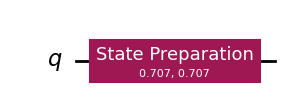

In [50]:
# Instantiate a quantum register for a single qubit.
single_qubit_qr = QuantumRegister(1, 'q')

# Coefficients for the arbitrary state.
a = 1
b = 1

# Create a quantum circuit which prepares the single qubit state into an arbitrary state based on coefficients a and b.
single_qubit_qc = QuantumCircuit(single_qubit_qr)
single_qubit_qc.prepare_state(state = [a/(np.sqrt(a**2 + b**2)), b/(np.sqrt(a**2 + b**2))], qubits = [0])

# Draw the circuit in mpl (matplotlib).
single_qubit_qc.draw('mpl')

In [51]:
rho_true = DensityMatrix.from_instruction(single_qubit_qc)
print("True density matrix:")
print(rho_true.data)

shadow = generate_classical_shadow(single_qubit_qc, 1000)
rho_shadow = reconstruct_state(shadow)
print("\nDensity matrix from shadow tomography:")
print(np.round(rho_shadow, 2))

print("\nDistance between the true and shadow tomography density matrices:")
print(np.round(operator_distance(rho_true.data, rho_shadow), 4))

True density matrix:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]

Density matrix from shadow tomography:
[[0.49+0.j   0.52-0.03j]
 [0.52+0.03j 0.51+0.j  ]]

Distance between the true and shadow tomography density matrices:
0.0539


#### With a Bell state

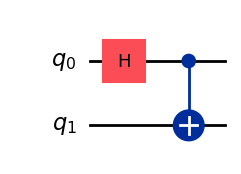

In [52]:
# Instantiate a quantum register with two qubits.
bell_state_qr = QuantumRegister (2, 'q')

# Create a quantum circuit with a hadamard gate acting on qubit 0
# and a CNOT gate with control qubit 0 and target qubit 1. This will prepare a bell state.
bell_state_qc = QuantumCircuit(bell_state_qr)
bell_state_qc.h(0)
bell_state_qc.cx(0, 1)

# Draw the ciruit in mpl (matplotlib).
bell_state_qc.draw("mpl")

In [53]:
rho_true = DensityMatrix.from_instruction(bell_state_qc)
print("True density matrix:")
print(rho_true.data)

shadow = generate_classical_shadow(bell_state_qc, 1000)
rho_shadow = reconstruct_state(shadow)
print("\nDensity matrix from shadow tomography:")
print(np.round(rho_shadow, 2))

print("\nDistance between the true and shadow tomography density matrices:")
print(np.round(operator_distance(rho_true.data, rho_shadow), 4))

True density matrix:
[[0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]]

Density matrix from shadow tomography:
[[ 0.52+0.j   -0.02+0.02j  0.02-0.01j  0.52-0.02j]
 [-0.02-0.02j -0.03+0.j   -0.02+0.01j -0.03+0.03j]
 [ 0.02+0.01j -0.02-0.01j -0.01+0.j   -0.  -0.01j]
 [ 0.52+0.02j -0.03-0.03j -0.  +0.01j  0.52+0.j  ]]

Distance between the true and shadow tomography density matrices:
0.1079


#### With a GHZ state

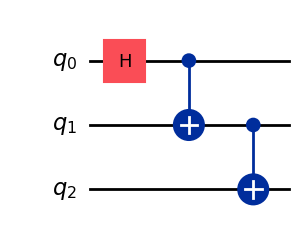

In [56]:
# Instantiate a quantum register with three qubits.
ghz_state_qr = QuantumRegister (3, 'q')

# Create a quantum circuit with a hadamard gate acting on qubit 0,
# a CNOT gate with control qubit 0 and target qubit 1,
# and a CNOT gate with control qubit 1 and target qubit 2. This will prepare a GHZ state.
ghz_state_qc = QuantumCircuit(ghz_state_qr)
ghz_state_qc.h(0)
ghz_state_qc.cx(0, 1)
ghz_state_qc.cx(1, 2)

# Draw the ciruit in mpl (matplotlib).
ghz_state_qc.draw("mpl")

In [57]:
rho_true = DensityMatrix.from_instruction(ghz_state_qc)
print("True density matrix:")
print(rho_true.data)

shadow = generate_classical_shadow(ghz_state_qc, 1000)
rho_shadow = reconstruct_state(shadow)
print("\nDensity matrix from shadow tomography:")
print(np.round(rho_shadow, 2))

print("\nDistance between the true and shadow tomography density matrices:")
print(np.round(operator_distance(rho_true.data, rho_shadow), 4))

True density matrix:
[[0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j]]

Density matrix from shadow tomography:
[[ 0.51+0.j    0.02-0.04j -0.06+0.j    0.  -0.01j  0.03+0.05j -0.01+0.05j
  -0.01+0.03j  0.45-0.01j]
 [ 0.02+0.04j  0.  +0.j    0.02+0.07j  0.01+0.02j  0.05+0.04j -0.02-0.03j
   0.01-0.01j -0.01-0.03j]
 [-0.06-0.j    0.02-0.07j -0.  +0.j    0.01-0.01j -0.06+0.03j -0.02-0.02j
  -0.02-0.02j -0.07-0.01j]
 [ 0.  +0.01j  0.01-0.02j  0.01+0.01j -0.03+0.j    0.07+0.02j  0.04-0.03j
  -0.05-0.01j  0.01+0.03j

## A Performance Comparison

The reason shadow tomography is appealing is because it supposedly offers a performance increase over traditional complete state tomography. For the paradigm I chose (random local pauli measurements) the size of the classical shadow required to estimate $M$ observables each with locality $L_i$ scales with:
$$ N_{tot} = \mathcal{O} \left( \frac{\log{M}}{\epsilon^2} \max_{1 \leq i \leq M} 4^{L_i} ||O_i||^2_\infty \right) $$
Where $ ||O||_\infty$ is the infinity norm and $\epsilon$ is the largest additive error we wish to estimate our observables within. More details are given in [Predicting Many Properties of a Quantum System from Very Few Measurements](#references).

### The Single Qubit Case

### The Two Qubit Case

### The Three Qubit Case

## References
1. [Predicting Many Properties of a Quantum System from Very Few Measurements](https://arxiv.org/pdf/2002.08953)
2. [Shadow Tomography of Quantum States](https://www.scottaaronson.com/papers/batch.pdf)
3. [Quantum State Tomography](https://research.physics.illinois.edu/QI/Photonics/tomography-files/tomo_chapter_2004.pdf)
4. [PennyLane Classical Shadows Demo](https://pennylane.ai/qml/demos/tutorial_classical_shadows/#huang2020)
5. [Qiskit API Reference](https://docs.quantum.ibm.com/api/qiskit)